In [5]:
# csce 487 intro to ML
# assignment 3 - Naive Bays Classifier & Logistic Regression
# collaborators : Changsu Kim, Jesse Reyes Cortes

import pandas as pd
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
import itertools
from random import sample 
import nltk
import matplotlib.pyplot as plt\n
plt.style.use('ggplot')
import seaborn as sns
nltk.download('wordnet')
nltk.download('punkt')



Predicting(Log):  [0, 1, 1, 1, 1, 1]


In [100]:
#################             NAIVE BAYES CLASSIFIER             #################

# part A: model code (design multinomial naive bayes)

data_A = [[2, 3, 2, 2, 3, 2, 2],
          [22, 22, 33, 2 , 2, 2],
          [3, 2, 4, 3, 8, 4],
          [2, 2, 3,2, 2, 2,2, 2, 2, 3],
          [2,3,2,4, 7,6,5,5,4],
          [2, 3, 9, 4, 4, 29, 29, 2],
          [2,9, 7, 8 , 23, 43, 29, 28],
          [2, 43,2, 4,3, 5, 4, 9, 20, 24],
          [2, 4 ,3 ,2, 3, 2],
          [2, 4, 8, 8, 4, 2,3,53],
          [4, 34, 23, 23, 23,2],
          [2, 3,3,2, 3,4, 5,3, 4],
          [2, 4, 2, 3, 2, 4, 5],
          [22,43,23,23,43,34,23,23,5],
          [23, 8, 2, 2, 3, 4]
         ]
label_A = [1,0,1,0,1,1,0,1,0,1,1,0,0,1,0]

test_A = [[2,4, 4, 23, 4, 4, 4],
          [2, 3, 2, 3, 2, 3],
          [4,5,4,3,3,2,43,32],
          [3,2,3,2,2,3],
          [2,3,2,3,2,4,2,42],
          [23,4,2,32]]

test_A_labels = [0,0,1,0,1,0]

class Multinomial_NB:
    def __init__(self, alpha=1.0):
        self.X = np.array([])
        self.Y = np.array([])
        self.alpha = alpha
        self.prior_h = 0
        self.prior_s = 0
        self.h_total = 0
        self.s_total = 0
        self.hashtable = {"spam" : {}, "ham" : {}}
        
        
    def fit(self, X, Y, **kwargs):
        self.X = X
        self.Y = Y
        
        if "alpha" in kwargs:
            self.apha = kwargs["alpha"]
        
        h_count = 0
        s_count = 0
        
        for i in range(0, len(self.X)):
            c = "spam"
            
            # spam
            if(self.Y[i]==1):
                s_count = s_count + 1
                self.s_total = self.s_total + len(self.X[i])
                c = "ham"
            # not spam
            else:
                h_count = h_count + 1
                self.h_total = self.h_total + len(self.X[i])
                
            for j in self.X[i]:
                #if it j feature is already in hashtable
                if str(j) in self.hashtable[c]:
                    self.hashtable[c][str(j)] = self.hashtable[c][str(j)] + 1
                else:
                    self.hashtable[c][str(j)] = 1

       # store classes as pie             
        self.prior_h = h_count/(h_count + s_count)
        self.prior_s = s_count/(h_count + s_count)

        
        
    def predict(self, X):
        
        predict = []
        
        log_post = self.predict_log_proba(X)
        
        for i in range(0, len(X)):
         
            prob_s = math.log(self.prior_s) + log_post[i][0]
            prob_h = math.log(self.prior_s) + log_post[i][1]
                
            if(prob_s > prob_h):
                predict.append(1)
            else:
                predict.append(0)
                
        return predict
    
    
    def predict_log_proba(self, X):
        
        log_post = np.zeros((len(X),2))
        
        for i in range(0, len(X)):
            
            #predicting spam
            post_s = 0
            #predicting ham
            post_h = 0
            for j in X[i]:
                p_s = self.alpha
                p_h = self.alpha
                if str(j) in self.hashtable["spam"]:
                    p_s = p_s + self.hashtable["spam"][str(j)]
                if str(j) in self.hashtable["ham"]:
                    p_h = p_h + self.hashtable["ham"][str(j)]
                    
                post_s = post_s + math.log(p_s/self.s_total)
                post_h = post_h + math.log(p_h/self.h_total)
      
            post_s = math.log(self.prior_s) + p_s
            
            post_h = math.log(self.prior_h) + p_h
            
            log_post[i][0] = post_s
            log_post[i][1] = post_h
                
        return log_post
    

    def predict_prob(self, X):
        
        predict = []
        
        for i in range(0, len(X)):
            
            #predicting spam
            prob_s = 1
            #predicting ham
            prob_h = 1
            for j in X[i]:
                p_s = self.alpha
                p_h = self.alpha
                if str(j) in self.hashtable["spam"]:
                    p_s = p_s + self.hashtable["spam"][str(j)]
                if str(j) in self.hashtable["ham"]:
                    p_h = p_h + self.hashtable["ham"][str(j)]
                    
                prob_s = prob_s * (p_s/self.s_total)
                prob_h = prob_h * (p_h/self.h_total)
      
            prob_s = self.prior_s * p_s
            
            prob_h = self.prior_h * p_h
                
            if(prob_s > prob_h):
                predict.append(1)
                
            else:
                predict.append(0)
                
        return predict
        
        
model = Multinomial_NB()
model.fit(data_A, label_A)
Y_hat = model.predict(test_A)
print("Predicting(Log): ", Y_hat)

Predicting(Log):  [0, 1, 1, 1, 1, 1]


In [37]:
# part B: exploratory data analysis
# B.2 read in SMSSpamCollection.csv as DataFrame



In [ ]:
# B.3 summerization of data in terms of mean, standard deviation, and quartiles


In [ ]:
# B.4 generate plot to display class distribution


In [ ]:
# part C: Feature Extraction
# C.5 normalize text


In [ ]:
# C.6 generate word clouds for both spam and ham emails (NLTK lib)


In [ ]:
# C.7 remove stop words & convert to numerical feature vectors


In [ ]:
# C.8 create data 


In [ ]:
# C.9 shuffle rows of data 


In [ ]:
# C.10 partition data (80% train - 20% test)


In [ ]:
# part D: Model Evaluation
# D.11 model selection via hyper-parameter tuning


In [ ]:
# D.12 generate ROC and AUC (bonus)


In [ ]:
# D.13 evaluate model on test day (Precision, Recall, F1 score, Confusion matrix, Accuracy)


In [ ]:
# D.14 multivariate bernoulli naive bayes model (bonus)


In [57]:
#################      LOGISTIC REGRESSION: MULTI-CLASS CLASSIFICATION      #################
# part A: model code
# A.15 design softmax  regression classifier
def one_hot_label(Y):
    W = []
    for i in Y:
        if i == 0:
            W.append([1, 0, 0])
        elif i == 1:
            W.append([0, 1, 0])
        else:
            W.append([0, 0, 1])
        Y_one_hot = np.array(W)
    return Y_one_hot;

y = [0,1,2,0,2,0,1,2,1,1]
print("Testing one_hot_label: ", one_hot_label(y))

Testing one_hot_label:  [[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


In [91]:
# A.16 compute softmax score 

def softmax(score):
    Y_prob = []
    
    
    
    for i in score:
        exp_sum = 0
        for j in i:
            exp_sum = exp_sum + math.exp(j)
        y_tmp = np.array([])
        for j in i:
            y_tmp = np.append(y_tmp, [(math.exp(j)/exp_sum)])
            
        Y_prob.append(y_tmp)
        
    return np.array(Y_prob)
    
    
    
score = [[3,1,2],
         [2,2,2],
         [3,2,9],
         [2,0,4],
         [2,4,9],
         [3,2,0],
         [2,4,8]]

print("Testing Softmax: ", softmax(score))

Testing Softmax:  [[6.65240956e-01 9.00305732e-02 2.44728471e-01]
 [3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [2.47037604e-03 9.08800555e-04 9.96620823e-01]
 [1.17310428e-01 1.58762400e-02 8.66813332e-01]
 [9.04959183e-04 6.68679417e-03 9.92408247e-01]
 [7.05384513e-01 2.59496460e-01 3.51190270e-02]
 [2.42825803e-03 1.79425348e-02 9.79629207e-01]]


In [92]:
# A.17 implement function to compute the cross-entropy loss
def cross_entropy_loss(Y_one_hot, Y_proba):
    cost = 0.0
    
    for i in range(0, len(Y_proba)):
        for j in range(0, len(Y_proba[0])):
                       cost = cost + (Y_one_hot[i][j]*math.log(Y_proba[i][j]))
                
    return -1*cost
                       

y_hot =[[1,0,0],
        [1,0,0],
        [0,1,0],
        [0,0,1],
        [0,0,1],
        [0,1,0],
        [1,0,0]]
                       
y_prob =[[.23,.23,.32],
        [.23,.34,.08],
        [.03,.28,.234],
        [.284,.294,.0384],
        [.0483,.84,.483],
        [.294,.38,.84],
        [.84,.342,.284]]

print("Testing Cross entropy loss: ", cross_entropy_loss(y_hot, y_prob))

Testing Cross entropy loss:  9.341691474055276


In [98]:
# A.18 implement a softmax_regression model class
class Softmax_Regression():
        def __init__(self):
            self.X = np.array([])
            self.Y = np.array([])
            self.learning_rate = 0
            self.epochs = 0
            self.tol = None
            self.regularizer = None
            self.lambd = 0.0
            self.early_stopping = False
            self.validation_fraction = 0.1
            
            
        def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, **kwargs):
            self.X = X
            self.Y = Y
            self.learning_rate = learning_rate
            self.epochs = epochs
            self.tol = tol
            self.regularizer = regularizer
            self.lambd = lambd
            self.early_stopping = early_stopping
            self.validation_fraction = validation_fraction
            
            
        def predict(self, X):
            print(X)
            
            
            

            

In [99]:
# B.19 read iris data (use sklearn.datasets.load_iris)
from sklearn.datasets import load_iris

data = pd.DataFrame(load_iris()["data"])

label = pd.DataFrame(load_iris()["target"])

In [22]:
# B.20 summerize variables in terms of mean, standard deviation, and quartiles (use technique from 2nd recitation)
data.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
# B.21 shuffle rows of data
data=data.sample(frac=1)

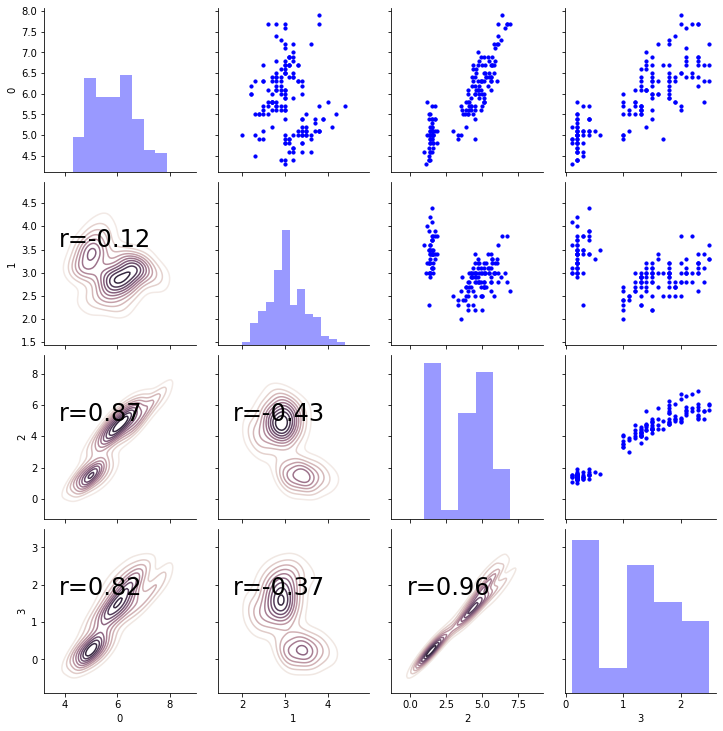

In [46]:
# B.22 generate plots (seaborn)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

def corrfunc(x,y, **kws):
   r,_= stats.pearsonr(x,y)
   ax = plt.gca()
   ax.annotate("r={:.2f}".format(r), xy =(.1,.6), xycoords = ax.transAxes, size = 24)
cmap = sns.cubehelix_palette(light = 1, dark = 0.1, hue = 0.5, as_cmap = True)
sns.set_context(font_scale=2)
#Pair grid set up
g = sns.PairGrid(data)
#Scatter plot on the upper triangle
g.map_upper(plt.scatter, s = 10, color = 'blue')
#Distribution on the diagonal
g.map_diag(sns.distplot, kde = False, color = 'blue')
#Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [26]:
# B.23 scale the features
data = (data - data.mean())/data.std()

In [27]:
# B.24 partion data
k =  int(abs(.8 * len(data)))
train_X = data[0:k]
test_X = data[k:len(data)]
train_Y = data[0:k]
test_Y = data[k:len(label)]
print("Training data size: ", len(train_X))
print("Test data size: ", len(test_X))
print("Training label size: ", len(train_Y))
print("Test label size: ", len(test_Y))

Training data size:  120
Test data size:  30
Training label size:  120
Test label size:  30


In [91]:
# part C: Model Evaluation
# C.25 model selection via hyper-parameter tuning


In [ ]:
# C.26 evaluate model on test data & report accuracy & confusion matrix


In [ ]:
# C.27 implement early stop in "fit" method for softmax regression model (bonus)


In [ ]:
# C.28 implement stochastic gradient descent logistic regression algorithm (bonus)